#  MAXIMUM SET SPLITTING / Максимальное расщепление множеств




In [4]:
import random
from IPython.core.display import SVG
import pyomo.environ as pyo
from pysat.solvers import Solver
from pysat.formula import CNF 
import py_svg_combinatorics as psc
from ipywidgets import widgets, HBox
from collections import Counter
from pprint import pprint
from random import randint
import numpy as np
from IPython.display import IFrame
import IPython
from copy import copy
import os
from pathlib import Path
from collections import defaultdict
from itertools import combinations
nbname = ''
try:
    nbname = __vsc_ipynb_file__
except:
    if 'COCALC_JUPYTER_FILENAME' in os.environ:
        nbname = os.environ['COCALC_JUPYTER_FILENAME']    
title_ = Path(nbname).stem.replace('-', '_').title()    
IFrame(f'https://discopal.ispras.ru/index.php?title=Hardprob/{title_}&useskin=cleanmonobook', width=1280, height=300)

ModuleNotFoundError: No module named 'pysat.solvers'

## Постановка задачи

Задача разрешения — для данного семейства «S» подмножеств конечного множества «U» решить, существует ли разбиение «U» на два подмножества элементов $U_1$, $U_2$ элементы, что $S$ «расщепляется» этим разбиением, т. е. ни один из элементов S не находится целиком в $U_1$ или $U_2$. Эту проблему иногда называют 2-раскрашиваемостью гиперграфа. 

Оптимизационная версия этой задачи называется «расщеплением максимального набора» и требует найти разбиение, которое максимизирует количество расщепляемых элементов S.

https://en.wikipedia.org/wiki/Set_splitting_problem

In [0]:
def get_random_subsets(N, sizes):
    res = []
    for size_, repeat_ in sizes:
        for _ in range(repeat_):
#             ok = False
#             while not ok:
#                 set_ = set(f"{i:02}" for i in np.random.choice(np.arange(1, N), size_))
#                 if len(set_) == size_:
#                     ok = True
            set_ = set()
            while len(set_) != size_:
                set_ = set(f"{i:02}" for i in np.random.choice(np.arange(1, N), size_))
            res.append(set_)
    return res


In [0]:
N = 20
sets = get_random_subsets(N, [(2, 10), (3, 2), (8, 1)])
#  [(num_of_elements, num_of_subset)]


In [0]:
svg = psc.subsets2svg(sets)
SVG(data=svg)
# Генерация происходит сверху вниз, вы можете наглядно проверить, что программа сгенирировала то, что надо

## Реализация в Pyomo

In [5]:
def print_solution(m):
    for v in m.component_data_objects(pyo.Var):
        if v.value and v.value > 0:
            print(str(v), v.value)

In [6]:
def get_model(sets):
    sets_ = sets
    if isinstance(sets_, dict):
       sets_ = [val for _, val in sets_.items()]

    model = pyo.ConcreteModel()

    model.S = [set(str(item) for item in sublist) for sublist in sets_] # список подмножеств
    model.m = len(model.S) # длина подмножества по вертикали
    model.I = range(model.m)
    model.U = sorted(set([str(item) for sublist in sets_ for item in sublist])) # universe множество всех элементов (отсортированных)
    model.n = len(model.U) # длина подмножества по горизонтали
    model.J = range(model.n)

    # как мы делаем разрез по элементам
    model.x = pyo.Var(model.J, domain=pyo.Binary)

    # пересекает ли подмножество этот разрез
    model.y = pyo.Var(model.I, domain=pyo.Binary)
    model.количество_разрезанных_подмножеств = pyo.Objective(expr = sum( model.y[i] for i in model.I), sense=pyo.maximize)

    # Для корректного разреза мы должны как выбирать, так и не выбирать элемент:
    # Выбираем элемент
    @model.Constraint(model.I)
    def надо_что_то_выбрать_в_множестве_чтобы_считать_его_разрезанным(m, i):
        return sum(m.x[j] for j in m.J if m.U[j] in m.S[i]) >= m.y[i]

    # Не выбираем элемент
    @model.Constraint(model.I)
    def надо_что_то_выбрать_в_множестве_чтобы_считать_его_разрезанным2(m, i):
        return len(m.S[i]) - sum(m.x[j] for j in m.J if m.U[j] in m.S[i]) >= m.y[i]

    return model


m = get_model(sets)
m.U, m.S

(['01',
  '02',
  '03',
  '04',
  '05',
  '09',
  '10',
  '12',
  '13',
  '14',
  '15',
  '17',
  '18',
  '19'],
 [{'03', '13'},
  {'09', '18'},
  {'12', '19'},
  {'13', '14'},
  {'10', '13'},
  {'02', '17'},
  {'09', '18'},
  {'05', '17'},
  {'01', '15'},
  {'04', '10'},
  {'05', '12', '19'},
  {'04', '09', '18'},
  {'02', '03', '04', '05', '12', '14', '18', '19'}])

In [7]:
ilp_solver = pyo.SolverFactory('cbc')
ilp_solver.solve(m).write()
print_solution(m)

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 13.0
  Upper bound: 13.0
  Number of objectives: 1
  Number of constraints: 26
  Number of variables: 27
  Number of binary variables: 27
  Number of integer variables: 27
  Number of nonzeros: 13
  Sense: maximize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  User time: -1.0
  System time: 0.01
  Wallclock time: 0.01
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Statistics: 
    Branch and bound: 

In [8]:
selected_items = [m.U[j] for j in m.J if m.x[j].value > 0]
selected_items


['04', '13', '15', '17', '18', '19']

In [9]:
selected_sets = [i for i in m.I if m.y[i].value > 0]
selected_sets

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

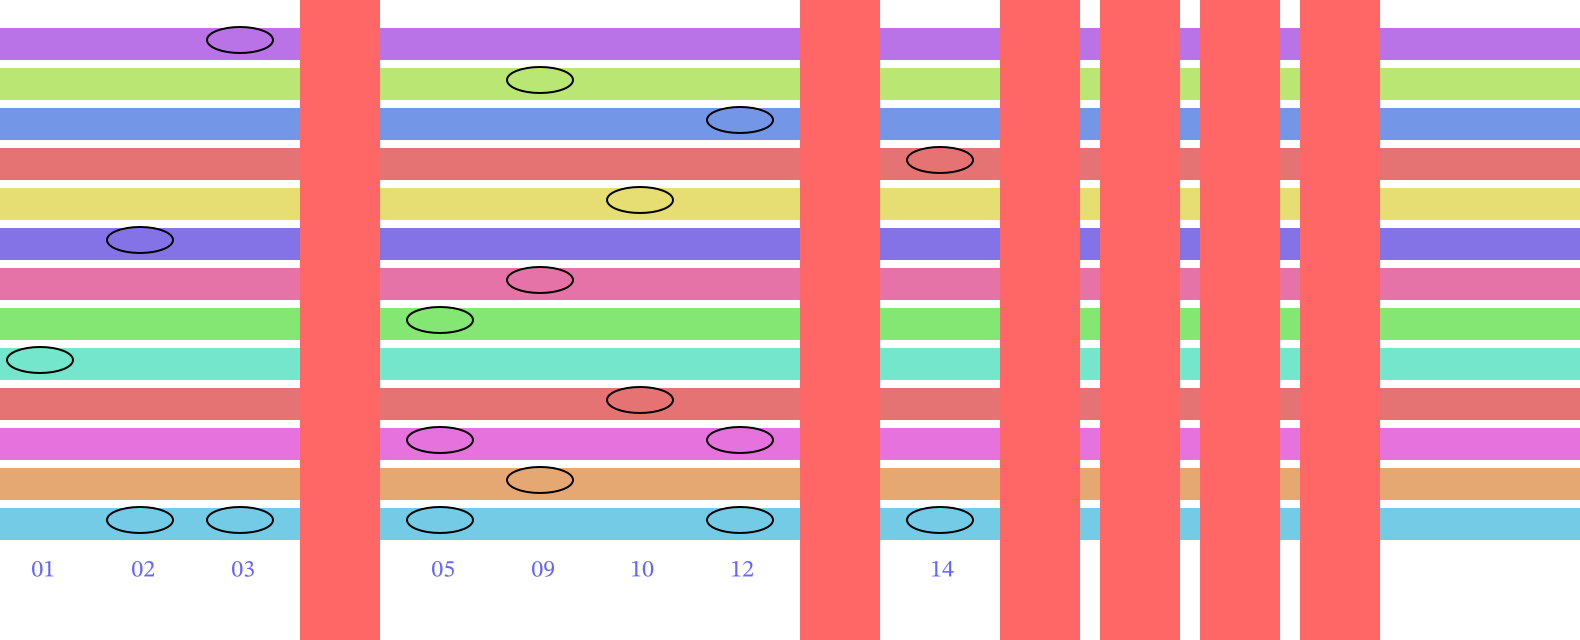

In [10]:
SVG(psc.subsets2svg(sets, selected=selected_sets, selected_items=selected_items))


In [11]:
sets

[{'03', '13'},
 {'09', '18'},
 {'12', '19'},
 {'13', '14'},
 {'10', '13'},
 {'02', '17'},
 {'09', '18'},
 {'05', '17'},
 {'01', '15'},
 {'04', '10'},
 {'05', '12', '19'},
 {'04', '09', '18'},
 {'02', '03', '04', '05', '12', '14', '18', '19'}]

| 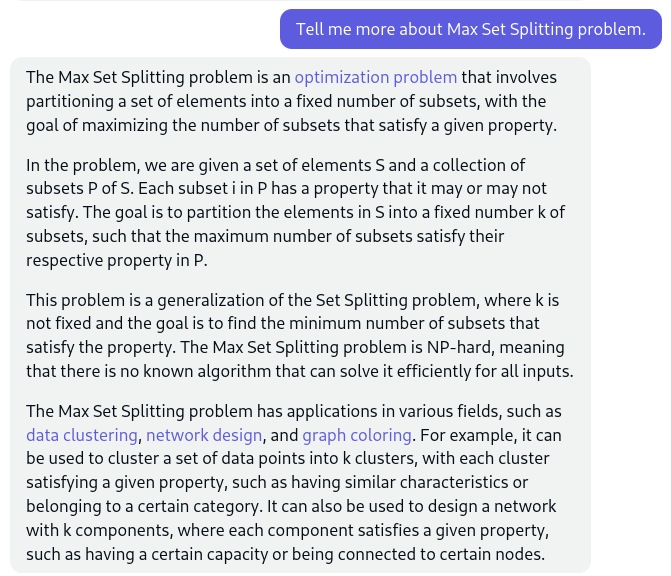  | 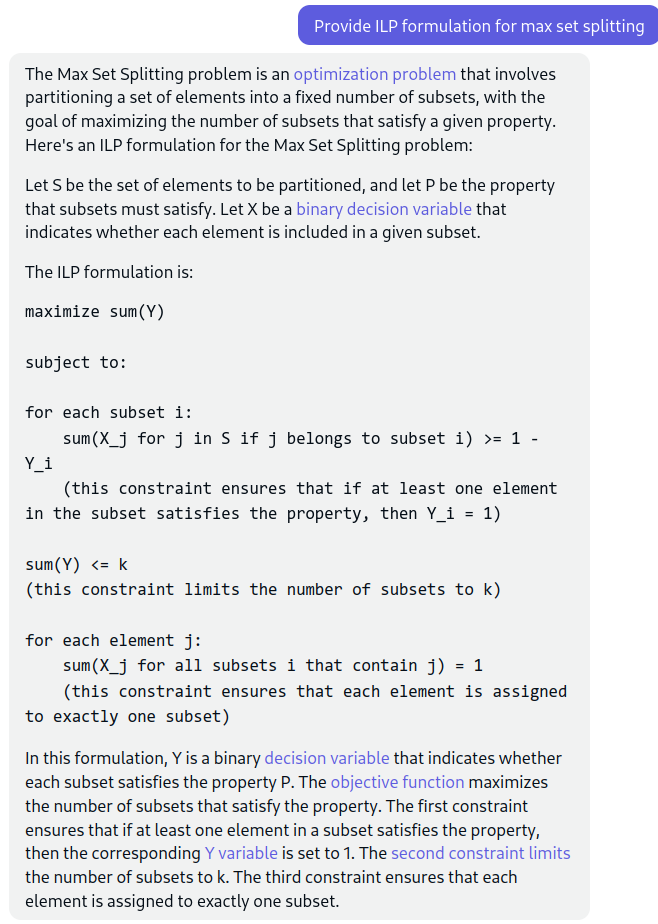 | 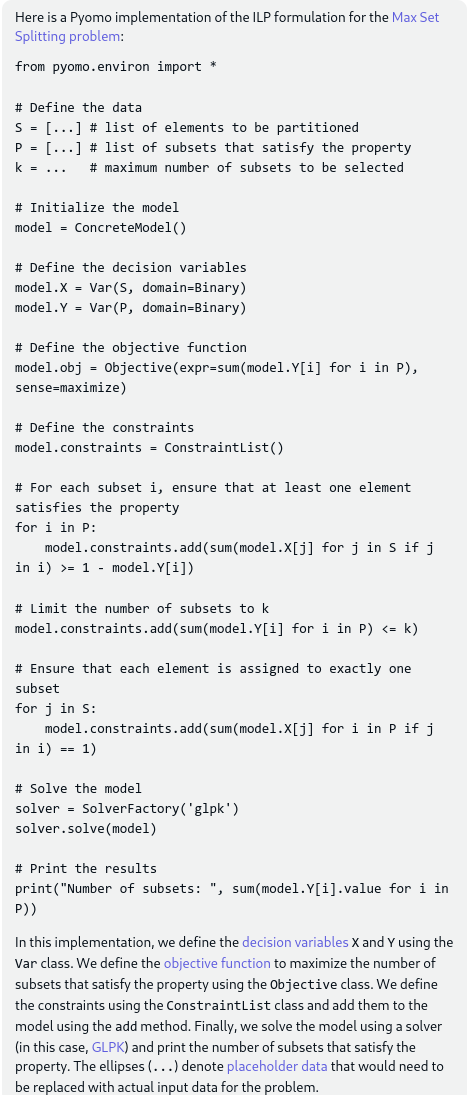 |




In [12]:
cnf3 = CNF(from_clauses=psc.rand3cnf(2, 6))
cnf3.clauses


[[-2, -1, -4], [4, -3, -2]]

In [13]:
from pysat.solvers import Solver

solver = Solver(bootstrap_with=cnf3)
res = solver.solve()
res 

True

In [14]:
print(solver.get_model())


[-1, -2, -3, -4]


In [15]:
print(list(solver.enum_models()))

[[-1, -2, -3, -4], [-1, -2, 3, -4], [-1, -2, 3, 4], [1, -2, 3, 4], [1, -2, -3, 4], [-1, -2, -3, 4], [1, -2, -3, -4], [1, -2, 3, -4], [1, 2, -3, -4], [-1, 2, -3, -4], [-1, 2, -3, 4], [-1, 2, 3, 4]]


In [16]:
def lit2str(lit, i=None):
    '''
    литерал в элемент-строку
    '''
    xn = abs(lit)
    mod = ''
    if i is not None:
        mod = f'^{{{i}}}'
    res = f'x{mod}_{{{xn}}}'
    if lit < 0:
        res = f'\overline{{{res}}}'
#         res = f'¬{{{res}}}'
    return res


In [17]:
# def clause2tex(clause):
#     '''
#     скобка в латех-строку
#     '''
#     res = '∧'.join([lit2str(l) for l in clause])
#     return res
0

0

In [18]:
def cnf32setsplitting(cnf):
    '''
    Будем считать, что на входе 3SAT формула. 
    Можно улучшить и т.п.
    '''
    n = cnf.nv
    m = len(cnf.clauses)
    
    sets = {}

    # для всех переменных добавляем пары литералов
    # разрезать это множество — выбрать значение.
    for j in range(1, n+1):
        sets[f'x_{{{j}}}'] = [lit2str(j), lit2str(-j)]         

    for i in range(m):
        clause = cnf.clauses[i]
        # Для скобок делает «отрезание от нуля» — специального символа «О»
        clause_set = ['O']
        for lit in clause:
            sets[f'C_{{{i}}}({lit2str(lit)})'] = [lit2str(lit, i), lit2str(-lit)]         
            clause_set.append(lit2str(lit, i))
        sets[f'C_{{{i}}}'] = clause_set
    
    return sets


In [19]:
cnf3 = CNF(from_clauses=psc.rand3cnf(1, 10))
cnf3.clauses

[[3, -2, 1]]

In [20]:
sets = cnf32setsplitting(cnf3)
pprint(sets)


{'C_{0}': ['O', 'x^{0}_{3}', '\\overline{x^{0}_{2}}', 'x^{0}_{1}'],
 'C_{0}(\\overline{x_{2}})': ['\\overline{x^{0}_{2}}', 'x_{2}'],
 'C_{0}(x_{1})': ['x^{0}_{1}', '\\overline{x_{1}}'],
 'C_{0}(x_{3})': ['x^{0}_{3}', '\\overline{x_{3}}'],
 'x_{1}': ['x_{1}', '\\overline{x_{1}}'],
 'x_{2}': ['x_{2}', '\\overline{x_{2}}'],
 'x_{3}': ['x_{3}', '\\overline{x_{3}}']}


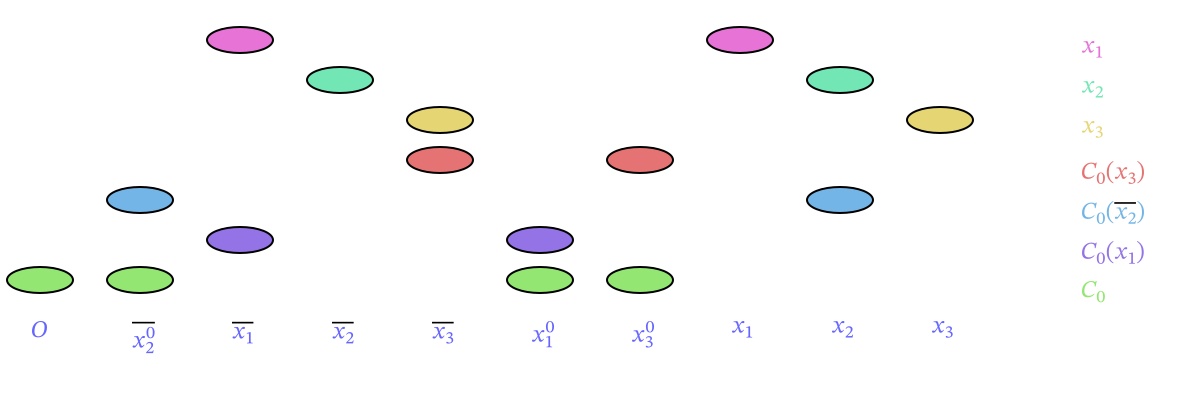

In [21]:
SVG(psc.subsets2svg(sets))

In [22]:
m = get_model(sets)
m.U, m.S


(['O',
  '\\overline{x^{0}_{2}}',
  '\\overline{x_{1}}',
  '\\overline{x_{2}}',
  '\\overline{x_{3}}',
  'x^{0}_{1}',
  'x^{0}_{3}',
  'x_{1}',
  'x_{2}',
  'x_{3}'],
 [{'\\overline{x_{1}}', 'x_{1}'},
  {'\\overline{x_{2}}', 'x_{2}'},
  {'\\overline{x_{3}}', 'x_{3}'},
  {'\\overline{x_{3}}', 'x^{0}_{3}'},
  {'\\overline{x^{0}_{2}}', 'x_{2}'},
  {'\\overline{x_{1}}', 'x^{0}_{1}'},
  {'O', '\\overline{x^{0}_{2}}', 'x^{0}_{1}', 'x^{0}_{3}'}])

In [23]:
# ilp_solver = pyo.SolverFactory('cbc')
ilp_solver.solve(m).write()
print_solution(m)


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 7.0
  Upper bound: 7.0
  Number of objectives: 1
  Number of constraints: 14
  Number of variables: 17
  Number of binary variables: 17
  Number of integer variables: 17
  Number of nonzeros: 7
  Sense: maximize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  User time: -1.0
  System time: 0.01
  Wallclock time: 0.01
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Statistics: 
    Branch and bound: 
  

In [24]:
selected_items = [m.U[j] for j in m.J if m.x[j].value > 0]
selected_items


['\\overline{x_{1}}', 'x^{0}_{3}', 'x_{2}', 'x_{3}']

In [25]:
splitted_sets = [i for i in m.I if m.y[i].value > 0]
splitted_sets


[0, 1, 2, 3, 4, 5, 6]

In [26]:
cnf3.clauses

[[3, -2, 1]]

In [27]:
pprint(sets)

{'C_{0}': ['O', 'x^{0}_{3}', '\\overline{x^{0}_{2}}', 'x^{0}_{1}'],
 'C_{0}(\\overline{x_{2}})': ['\\overline{x^{0}_{2}}', 'x_{2}'],
 'C_{0}(x_{1})': ['x^{0}_{1}', '\\overline{x_{1}}'],
 'C_{0}(x_{3})': ['x^{0}_{3}', '\\overline{x_{3}}'],
 'x_{1}': ['x_{1}', '\\overline{x_{1}}'],
 'x_{2}': ['x_{2}', '\\overline{x_{2}}'],
 'x_{3}': ['x_{3}', '\\overline{x_{3}}']}


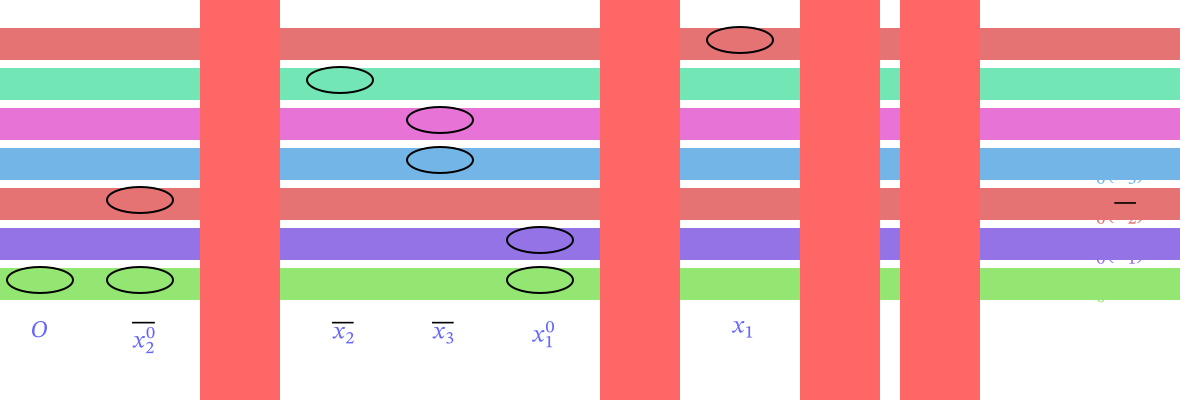

In [28]:
SVG(psc.subsets2svg(sets, selected_items=selected_items, selected=splitted_sets))

In [29]:
cnf3 = CNF(from_clauses=psc.rand3cnf(2, 7))
cnf3.clauses

[[-2, -3, 1], [-2, 3, -4]]

In [30]:
sets = cnf32setsplitting(cnf3)
pprint(sets)

{'C_{0}': ['O', '\\overline{x^{0}_{2}}', '\\overline{x^{0}_{3}}', 'x^{0}_{1}'],
 'C_{0}(\\overline{x_{2}})': ['\\overline{x^{0}_{2}}', 'x_{2}'],
 'C_{0}(\\overline{x_{3}})': ['\\overline{x^{0}_{3}}', 'x_{3}'],
 'C_{0}(x_{1})': ['x^{0}_{1}', '\\overline{x_{1}}'],
 'C_{1}': ['O', '\\overline{x^{1}_{2}}', 'x^{1}_{3}', '\\overline{x^{1}_{4}}'],
 'C_{1}(\\overline{x_{2}})': ['\\overline{x^{1}_{2}}', 'x_{2}'],
 'C_{1}(\\overline{x_{4}})': ['\\overline{x^{1}_{4}}', 'x_{4}'],
 'C_{1}(x_{3})': ['x^{1}_{3}', '\\overline{x_{3}}'],
 'x_{1}': ['x_{1}', '\\overline{x_{1}}'],
 'x_{2}': ['x_{2}', '\\overline{x_{2}}'],
 'x_{3}': ['x_{3}', '\\overline{x_{3}}'],
 'x_{4}': ['x_{4}', '\\overline{x_{4}}']}


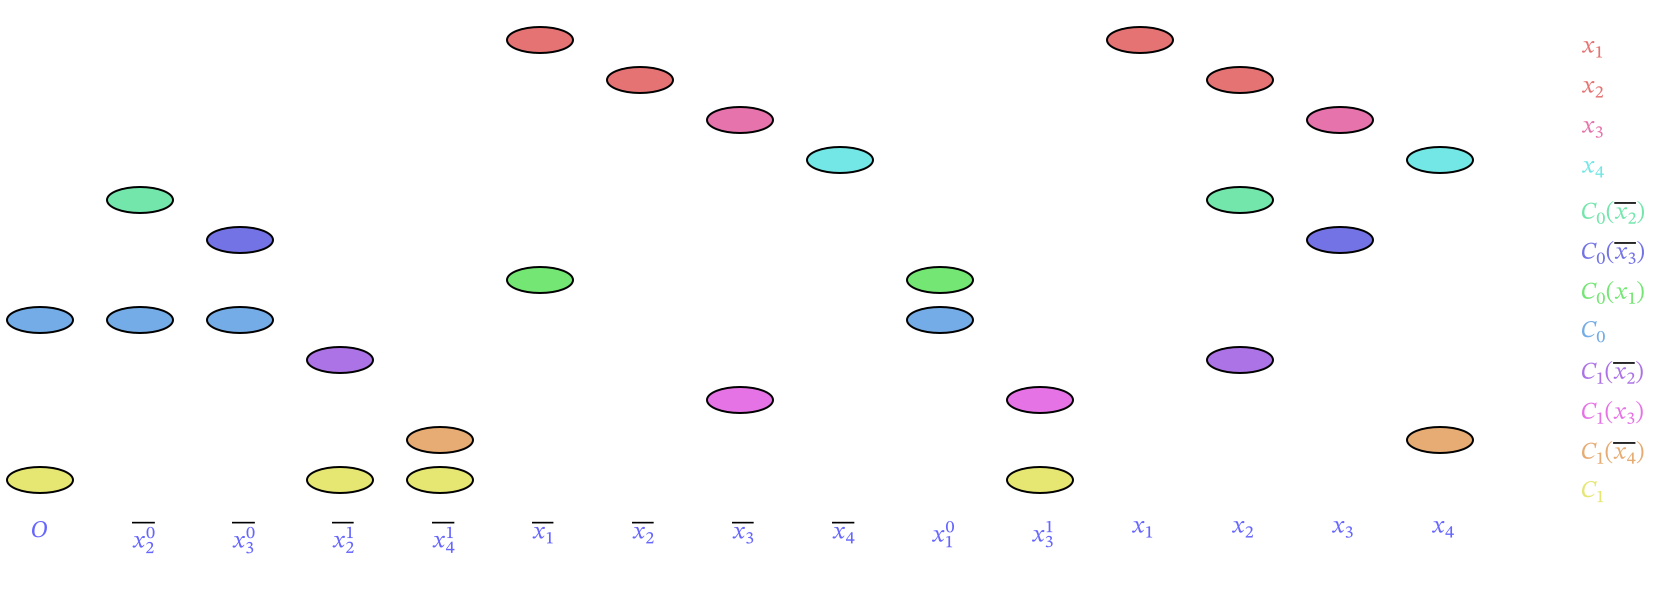

In [31]:
SVG(psc.subsets2svg(sets))

In [32]:
m = get_model(sets)
m.U, m.S


(['O',
  '\\overline{x^{0}_{2}}',
  '\\overline{x^{0}_{3}}',
  '\\overline{x^{1}_{2}}',
  '\\overline{x^{1}_{4}}',
  '\\overline{x_{1}}',
  '\\overline{x_{2}}',
  '\\overline{x_{3}}',
  '\\overline{x_{4}}',
  'x^{0}_{1}',
  'x^{1}_{3}',
  'x_{1}',
  'x_{2}',
  'x_{3}',
  'x_{4}'],
 [{'\\overline{x_{1}}', 'x_{1}'},
  {'\\overline{x_{2}}', 'x_{2}'},
  {'\\overline{x_{3}}', 'x_{3}'},
  {'\\overline{x_{4}}', 'x_{4}'},
  {'\\overline{x^{0}_{2}}', 'x_{2}'},
  {'\\overline{x^{0}_{3}}', 'x_{3}'},
  {'\\overline{x_{1}}', 'x^{0}_{1}'},
  {'O', '\\overline{x^{0}_{2}}', '\\overline{x^{0}_{3}}', 'x^{0}_{1}'},
  {'\\overline{x^{1}_{2}}', 'x_{2}'},
  {'\\overline{x_{3}}', 'x^{1}_{3}'},
  {'\\overline{x^{1}_{4}}', 'x_{4}'},
  {'O', '\\overline{x^{1}_{2}}', '\\overline{x^{1}_{4}}', 'x^{1}_{3}'}])

In [33]:
# ilp_solver = pyo.SolverFactory('cbc')
ilp_solver.solve(m).write()
print_solution(m)


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 12.0
  Upper bound: 12.0
  Number of objectives: 1
  Number of constraints: 24
  Number of variables: 27
  Number of binary variables: 27
  Number of integer variables: 27
  Number of nonzeros: 12
  Sense: maximize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  User time: -1.0
  System time: 0.01
  Wallclock time: 0.02
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Statistics: 
    Branch and bound: 

In [34]:
selected_items = [m.U[j] for j in m.J if m.x[j].value > 0]
selected_items


['\\overline{x^{0}_{3}}',
 '\\overline{x^{1}_{4}}',
 '\\overline{x_{1}}',
 '\\overline{x_{3}}',
 '\\overline{x_{4}}',
 'x_{2}']

In [35]:
splitted_sets = [i for i in m.I if m.y[i].value > 0]
splitted_sets

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

In [36]:
cnf3.clauses

[[-2, -3, 1], [-2, 3, -4]]

In [37]:
pprint(sets)

{'C_{0}': ['O', '\\overline{x^{0}_{2}}', '\\overline{x^{0}_{3}}', 'x^{0}_{1}'],
 'C_{0}(\\overline{x_{2}})': ['\\overline{x^{0}_{2}}', 'x_{2}'],
 'C_{0}(\\overline{x_{3}})': ['\\overline{x^{0}_{3}}', 'x_{3}'],
 'C_{0}(x_{1})': ['x^{0}_{1}', '\\overline{x_{1}}'],
 'C_{1}': ['O', '\\overline{x^{1}_{2}}', 'x^{1}_{3}', '\\overline{x^{1}_{4}}'],
 'C_{1}(\\overline{x_{2}})': ['\\overline{x^{1}_{2}}', 'x_{2}'],
 'C_{1}(\\overline{x_{4}})': ['\\overline{x^{1}_{4}}', 'x_{4}'],
 'C_{1}(x_{3})': ['x^{1}_{3}', '\\overline{x_{3}}'],
 'x_{1}': ['x_{1}', '\\overline{x_{1}}'],
 'x_{2}': ['x_{2}', '\\overline{x_{2}}'],
 'x_{3}': ['x_{3}', '\\overline{x_{3}}'],
 'x_{4}': ['x_{4}', '\\overline{x_{4}}']}


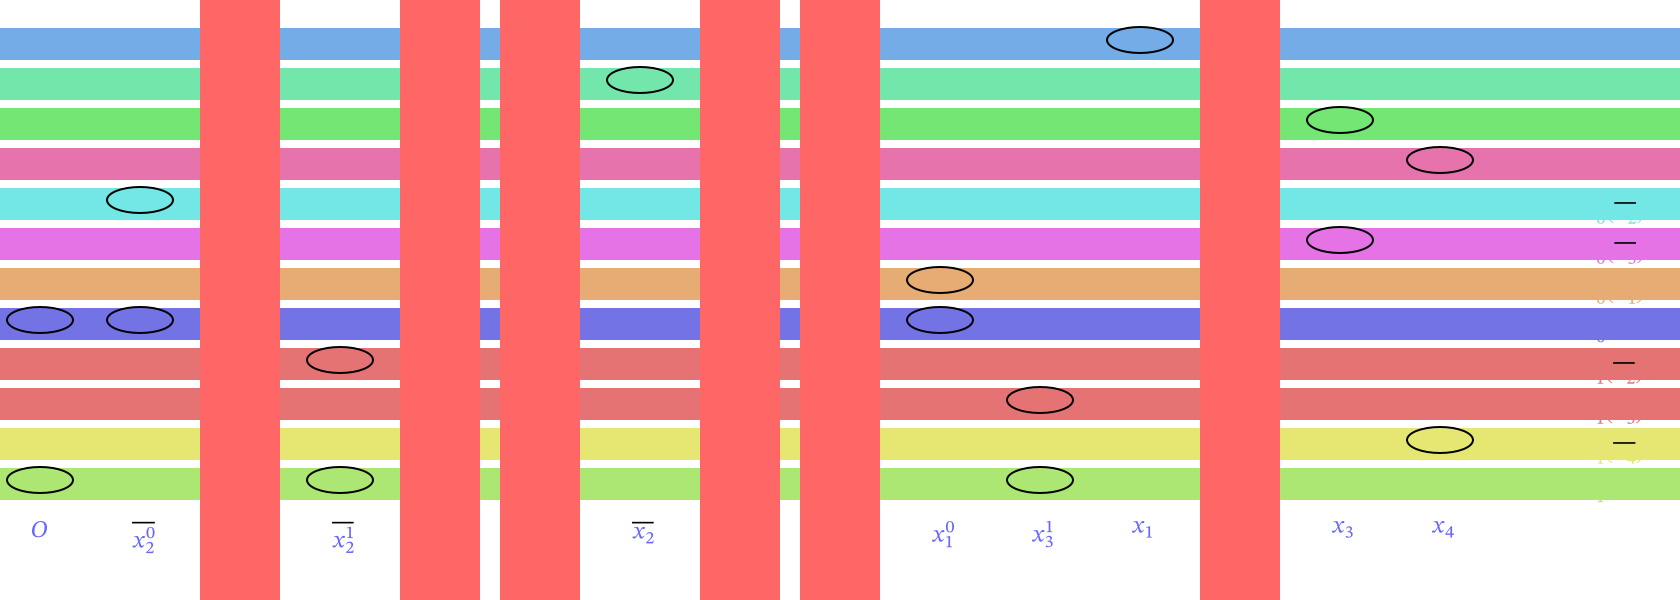

In [38]:
SVG(psc.subsets2svg(sets, selected_items=selected_items, selected=splitted_sets))

In [39]:
import re
def max_set_splitting_sol_2_3satsol(m, sets):
    '''
    Конвертация решения этой задачи через ЦЛП, в решение для 3SAT
    '''
    # словарь номер_переменной_в_3SAT → значение (0/1)
    satsol = {}
    
    selected_items = [m.U[j] for j in m.J if m.x[j].value > 0]
    splitted_sets = [i for i in m.I if m.y[i].value > 0]
    O_value = m.y[0].value
    need_negation = O_value
    re_ = re.compile(r"x\_\{(?P<varn>\d+)\}")
    for j in m.J:
        rm = re_.match(m.U[j])
        if rm:
            val = int(m.x[j].value)
            varn = int(rm.group('varn'))
            if need_negation:
                val = not val
            assert varn not in satsol or val == satsol[varn]
            satsol[varn] = val
    return satsol     


In [40]:
cnf.clauses

NameError: name 'cnf' is not defined

In [0]:
max_set_splitting_sol_2_3satsol(m, sets)

{1: True, 2: True, 3: True}

In [0]:
def solve_cnf_by_set_splitting(cnf):
    sets = cnf32setsplitting(cnf)
    m = get_model(sets)
    ilp_solver.solve(m)   
    sol = max_set_splitting_sol_2_3satsol(m, sets)
    return sol  

In [0]:
cnf = CNF(from_clauses=psc.rand3cnf(7, 4))
cnf.clauses, solve_cnf_by_set_splitting(cnf)

([[-3, 1, -2], [-1, 2, 3], [-1, 3, 1], [2, 3, 1], [1, 2, -3], [2, 1, -1], [1, -2, 3]], {1: True, 2: True, 3: True})

## **Создание Тестов**



In [0]:
from pyomo.opt import SolverStatus
from pyomo.opt import TerminationCondition


In [0]:
def create_tests(num_of_clauses):
    cnf = CNF(from_clauses=psc.rand3cnf(num_of_clauses, 3))
    test_sets = cnf32setsplitting(cnf)
    test_model = get_model(test_sets)
    test_result_struct = ilp_solver.solve(test_model)
    test_result = (test_result_struct.solver.status == SolverStatus.ok and test_result_struct.solver.termination_condition == TerminationCondition.optimal)
    test_no_result = (test_result_struct.solver.termination_condition == TerminationCondition.infeasible)
    
    py3sat_test_solver = Solver(bootstrap_with=cnf)
    py3sat_test_result = py3sat_test_solver.solve()
    
    if ((py3sat_test_result == True and test_no_result)\
        or\
        (py3sat_test_result == False and test_result)):
        print("SOLUTION FAILED num amount: ", num_of_clauses, "Pyomo: ", test_result, ", test no result: ", test_no_result, ", 3SAT: ", py3sat_test_result)
        return False, test_sets, test_model, py3sat_test_solver.get_model()
    else:
        print("SOLUTION FOUND num amount: ", num_of_clauses, ", answer: ", py3sat_test_result)
        return True, test_sets, test_model, py3sat_test_solver.get_model()

In [0]:
create_tests(5)

SOLUTION FOUND num amount: 

5

, answer: 

True

(True, {'x_{1}': ['x_{1}', '\\overline{x_{1}}'], 'x_{2}': ['x_{2}', '\\overline{x_{2}}'], 'C_{0}(x_{1})': ['x^{0}_{1}', '\\overline{x_{1}}'], 'C_{0}(x_{2})': ['x^{0}_{2}', '\\overline{x_{2}}'], 'C_{0}': ['O', 'x^{0}_{1}', 'x^{0}_{1}', 'x^{0}_{2}'], 'C_{1}(\\overline{x_{1}})': ['\\overline{x^{1}_{1}}', 'x_{1}'], 'C_{1}(\\overline{x_{2}})': ['\\overline{x^{1}_{2}}', 'x_{2}'], 'C_{1}(x_{1})': ['x^{1}_{1}', '\\overline{x_{1}}'], 'C_{1}': ['O', '\\overline{x^{1}_{1}}', '\\overline{x^{1}_{2}}', 'x^{1}_{1}'], 'C_{2}(x_{1})': ['x^{2}_{1}', '\\overline{x_{1}}'], 'C_{2}(\\overline{x_{1}})': ['\\overline{x^{2}_{1}}', 'x_{1}'], 'C_{2}(\\overline{x_{2}})': ['\\overline{x^{2}_{2}}', 'x_{2}'], 'C_{2}': ['O', 'x^{2}_{1}', '\\overline{x^{2}_{1}}', '\\overline{x^{2}_{2}}'], 'C_{3}(x_{1})': ['x^{3}_{1}', '\\overline{x_{1}}'], 'C_{3}(\\overline{x_{1}})': ['\\overline{x^{3}_{1}}', 'x_{1}'], 'C_{3}(x_{2})': ['x^{3}_{2}', '\\overline{x_{2}}'], 'C_{3}': ['O', 'x^{3}_{1}', '\\overline{x^{3}_{1}}', 'x^{3}_{2}']

In [0]:
for i in range(1, 50):
    result_of_tests = create_tests(i)
    done = result_of_tests[0]
    bad_case_sets = result_of_tests[1]
    model = result_of_tests[2]
    py3sat_model = result_of_tests[3]
    if done != True:
        break

SOLUTION FOUND num amount: 

1

, answer: 

True

SOLUTION FOUND num amount: 

2

, answer: 

True

SOLUTION FOUND num amount: 

3

, answer: 

True

SOLUTION FOUND num amount: 

4

, answer: 

True

SOLUTION FOUND num amount: 

5

, answer: 

True

SOLUTION FOUND num amount: 

6

, answer: 

True

SOLUTION FOUND num amount: 

7

, answer: 

True

SOLUTION FOUND num amount: 

8

, answer: 

True

SOLUTION FOUND num amount: 

9

, answer: 

True

SOLUTION FAILED num amount: 

10

Pyomo: 

True

, test no result: 

False

, 3SAT: 

False

In [0]:
print(bad_case_sets, '\n')

bad_case_selected = [model.U[j] for j in model.J if model.x[j].value > 0]
bad_case_splitted = [i for i in model.I if model.y[i].value > 0]

print("-----\n")
print(bad_case_selected)
print(bad_case_splitted)

{'x_{1}': ['x_{1}', '\\overline{x_{1}}'], 'x_{2}': ['x_{2}', '\\overline{x_{2}}'], 'C_{0}(x_{1})': ['x^{0}_{1}', '\\overline{x_{1}}'], 'C_{0}(x_{2})': ['x^{0}_{2}', '\\overline{x_{2}}'], 'C_{0}': ['O', 'x^{0}_{1}', 'x^{0}_{1}', 'x^{0}_{2}'], 'C_{1}(x_{1})': ['x^{1}_{1}', '\\overline{x_{1}}'], 'C_{1}(\\overline{x_{2}})': ['\\overline{x^{1}_{2}}', 'x_{2}'], 'C_{1}(\\overline{x_{1}})': ['\\overline{x^{1}_{1}}', 'x_{1}'], 'C_{1}': ['O', 'x^{1}_{1}', '\\overline{x^{1}_{2}}', '\\overline{x^{1}_{1}}'], 'C_{2}(x_{1})': ['x^{2}_{1}', '\\overline{x_{1}}'], 'C_{2}(\\overline{x_{1}})': ['\\overline{x^{2}_{1}}', 'x_{1}'], 'C_{2}(x_{2})': ['x^{2}_{2}', '\\overline{x_{2}}'], 'C_{2}': ['O', 'x^{2}_{1}', '\\overline{x^{2}_{1}}', 'x^{2}_{2}'], 'C_{3}(x_{1})': ['x^{3}_{1}', '\\overline{x_{1}}'], 'C_{3}(x_{2})': ['x^{3}_{2}', '\\overline{x_{2}}'], 'C_{3}': ['O', 'x^{3}_{1}', 'x^{3}_{2}', 'x^{3}_{1}'], 'C_{4}(x_{1})': ['x^{4}_{1}', '\\overline{x_{1}}'], 'C_{4}(x_{2})': ['x^{4}_{2}', '\\overline{x_{2}}'], '

-----


['O', '\\overline{x^{1}_{1}}', '\\overline{x^{2}_{1}}', '\\overline{x^{5}_{1}}', '\\overline{x^{6}_{1}}', '\\overline{x^{7}_{1}}', '\\overline{x^{9}_{1}}', '\\overline{x_{1}}', '\\overline{x_{2}}', 'x_{2}']

[0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35]

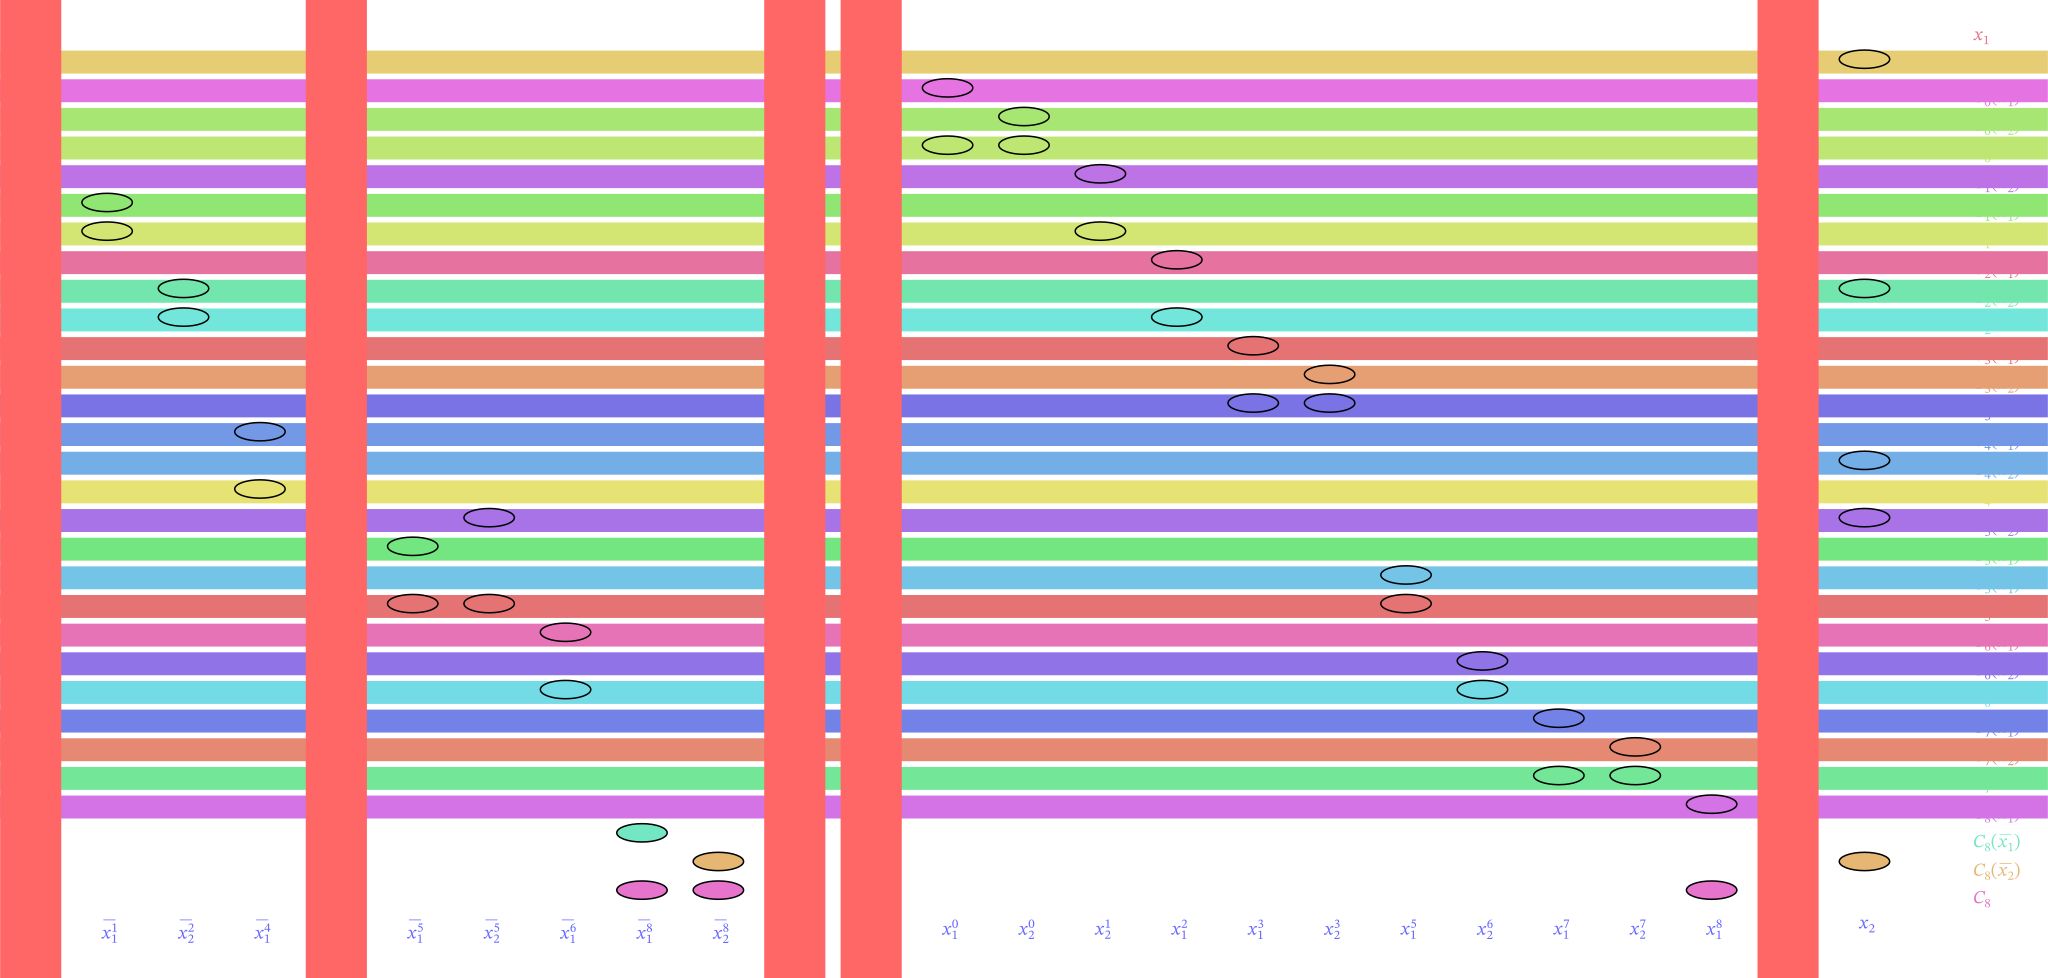

In [0]:
SVG(psc.subsets2svg(got_sets, selected_items=result_selected, selected=ssplitted_sets))

Как можем заметить, мы выявили плохой тест кейс
